<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/Base_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
pip install pandas numpy scikit-learn tensorflow

In [31]:
# -*- coding: utf-8 -*-
"""
1D CNN for Tabular Production Classification

This script loads tabular data, preprocesses it (including reshaping for CNN),
 trains a 1D Convolutional Neural Network (CNN),
and evaluates its performance using Confusion Matrix and Macro F1 Score.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [32]:
# Suppress specific warnings from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics._classification')

# --- Configuration ---
TRAIN_FILE = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv'
VALIDATION_FILE = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv'
TEST_FILE = '/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv'
TARGET_COLUMN = 'Production (M.Ton)' # Corrected quotes
INITIAL_N_CLASSES = 5 # Desired number of classes for binning
CLASS_LABELS = ['very low', 'low', 'medium', 'high', 'very high'] # Corresponding to bins 0-4
EPOCHS = 20 # Number of training epochs as requested
BATCH_SIZE = 32
RANDOM_STATE = 42 # For reproducibility

# Set random seeds for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [33]:
# --- Data Loading ---
def load_data(file_path):
    """Loads data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}. Shape: {df.shape}")
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found in {file_path}") # Corrected quotes
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [34]:
# --- Preprocessing ---
def preprocess_data_cnn(df_train, df_val, df_test, n_classes_target):
    """Preprocesses the training, validation, and test data for 1D CNN.

    Returns:
        Tuple containing preprocessed data and the actual number of classes used.
    """
    print("\n--- Starting Data Preprocessing for CNN ---")

    X_train = df_train.drop(TARGET_COLUMN, axis=1)
    y_train_raw = df_train[TARGET_COLUMN]
    X_val = df_val.drop(TARGET_COLUMN, axis=1)
    y_val_raw = df_val[TARGET_COLUMN]
    X_test = df_test.drop(TARGET_COLUMN, axis=1)
    y_test_raw = df_test[TARGET_COLUMN]

    train_cols = X_train.columns
    X_val = X_val.reindex(columns=train_cols, fill_value=0)
    X_test = X_test.reindex(columns=train_cols, fill_value=0)

    print(f"Initial feature shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    actual_n_classes = n_classes_target
    print(f"Attempting to bin target variable '{TARGET_COLUMN}' into {n_classes_target} categories...") # Corrected quotes
    try:
        bins = pd.qcut(y_train_raw, q=n_classes_target, labels=False, duplicates='drop')
        bin_edges = pd.qcut(y_train_raw, q=n_classes_target, retbins=True, duplicates='drop')[1]
        print(f"Calculated bin edges based on training data: {bin_edges}")

        y_train_binned = pd.cut(y_train_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_val_binned = pd.cut(y_val_raw, bins=bin_edges, labels=False, include_lowest=True)
        y_test_binned = pd.cut(y_test_raw, bins=bin_edges, labels=False, include_lowest=True)

        y_val_binned.fillna(0, inplace=True)
        y_test_binned.fillna(0, inplace=True)
        y_val_binned = y_val_binned.astype(int)
        y_test_binned = y_test_binned.astype(int)

        print("Target variable distribution after binning (Train):")
        print(y_train_binned.value_counts(normalize=True).sort_index())
        actual_n_classes = y_train_binned.nunique()
        if actual_n_classes != n_classes_target:
            print(f"Warning: Binning resulted in {actual_n_classes} classes, not the target {n_classes_target}.")

    except ValueError as e:
        print(f"Error during quantile binning: {e}. Falling back to LabelEncoder.")
        encoder = LabelEncoder()
        y_train_binned = encoder.fit_transform(y_train_raw)
        y_val_binned = encoder.transform(y_val_raw)
        y_test_binned = encoder.transform(y_test_raw)
        actual_n_classes = len(encoder.classes_)
        print(f"Using LabelEncoder resulted in {actual_n_classes} classes.")

    print(f"Final number of classes used for encoding: {actual_n_classes}")

    print("One-hot encoding target variable...")
    y_train_encoded = to_categorical(y_train_binned, num_classes=actual_n_classes)
    y_val_encoded = to_categorical(y_val_binned, num_classes=actual_n_classes)
    y_test_encoded = to_categorical(y_test_binned, num_classes=actual_n_classes)

    print("Scaling numerical features...")
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    print(f"Identified {len(numerical_cols)} numerical columns for scaling.")

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print("Features scaled using StandardScaler.")
    # Reshape data for 1D CNN: (n_samples, n_features, 1 channel)
    print("Reshaping features for 1D CNN...")
    X_train_reshaped = X_train_scaled.values.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_val_reshaped = X_val_scaled.values.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
    X_test_reshaped = X_test_scaled.values.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    print(f"Reshaped feature shapes: Train={X_train_reshaped.shape}, Val={X_val_reshaped.shape}, Test={X_test_reshaped.shape}")

    print("--- Data Preprocessing Finished ---")
    return X_train_reshaped, y_train_encoded, y_train_binned, \
           X_val_reshaped, y_val_encoded, y_val_binned, \
           X_test_reshaped, y_test_encoded, y_test_binned, actual_n_classes


In [35]:
# --- Model Building ---
def build_cnn_model(input_shape, num_classes):
    """Builds a simple 1D CNN model."""
    model = Sequential([
        InputLayer(input_shape=input_shape), # Shape: (n_features, 1)
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'), # Corrected quotes
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'), # Corrected quotes
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'), # Corrected quotes
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Output layer, Corrected quotes
    ])
    model.compile(optimizer='adam', # Corrected quotes
                  loss='categorical_crossentropy', # Corrected quotes
                  metrics=['accuracy']) # Corrected quotes
    print("\n--- Model Summary ---")
    model.summary()
    return model


In [36]:
# --- Evaluation Metrics ---
def print_cnn_evaluation_metrics(y_true, y_pred_classes, num_classes_actual, class_labels_config, dataset_name="Dataset"):
    """Calculates and prints Confusion Matrix and Macro F1 Score."""
    print(f"\n--- Evaluation Metrics for {dataset_name} ---")

    macro_f1 = f1_score(y_true, y_pred_classes, average='macro', zero_division=0) # Corrected quotes
    print(f"Macro F1 Score: {macro_f1:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_classes)

    # Determine labels for the confusion matrix plot
    labels_to_use = None
    unique_labels_in_data = sorted(np.unique(y_true))
    if len(class_labels_config) == num_classes_actual and len(unique_labels_in_data) == num_classes_actual:
        labels_to_use = [class_labels_config[i] for i in unique_labels_in_data]
    else:
        labels_to_use = [str(label) for label in unique_labels_in_data]
        print(f"Warning: Class label mismatch or inconsistency. Using numerical labels for confusion matrix: {labels_to_use}")



    # Optional: Plot confusion matrix (useful in Colab/Jupyter)
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_to_use, yticklabels=labels_to_use)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.show()
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")

    print("-----------------------------------------")

In [37]:
# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Production Classification Task with 1D CNN...")

    df_train = load_data(TRAIN_FILE)
    df_val = load_data(VALIDATION_FILE)
    df_test = load_data(TEST_FILE)

    if df_train is None or df_val is None or df_test is None:
        print("\nError loading data. Exiting.")
        exit()

    X_train_reshaped, y_train_encoded, y_train_binned, \
    X_val_reshaped, y_val_encoded, y_val_binned, \
    X_test_reshaped, y_test_encoded, y_test_binned, actual_n_classes = preprocess_data_cnn(df_train, df_val, df_test, INITIAL_N_CLASSES)

    if X_train_reshaped is None:
        print("\nError during preprocessing. Exiting.")
        exit()


Starting Production Classification Task with 1D CNN...
Successfully loaded /content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv. Shape: (3584, 84)
Successfully loaded /content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv. Shape: (768, 84)
Successfully loaded /content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv. Shape: (768, 84)

--- Starting Data Preprocessing for CNN ---
Initial feature shapes: Train=(3584, 83), Val=(768, 83), Test=(768, 83)
Attempting to bin target variable 'Production (M.Ton)' into 5 categories...
Calculated bin edges based on training data: [     0.       550.2     1447.52    3064.522   6362.6   544979.54 ]
Target variable distribution after binning (Train):
Production (M.Ton)
0    0.200056
1    0.200056
2    0.199777
3    0.200056
4    0.200056
Name: proportion, dtype: float64
Final number of classes used for encoding: 5
One-hot encoding target variable...
Scaling numerical features...
Identified 83 numerical colu

In [38]:
    # CNN input shape is (num_features, 1 channel)
    input_shape_cnn = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    model = build_cnn_model(input_shape_cnn, actual_n_classes)

    print(f"\n--- Starting Model Training ({EPOCHS} Epochs) ---")
    history = model.fit(
        X_train_reshaped,
        y_train_encoded,
        epochs=EPOCHS, # Fixed number of epochs
        batch_size=BATCH_SIZE,
        validation_data=(X_val_reshaped, y_val_encoded),
        verbose=1 # Show progress
    )
    print("--- Model Training Finished ---")


--- Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 83, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 41, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 41, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       128,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,941 (527.11 KB)

 Trainable params: 134,941 (527.11 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training (20 Epochs) ---
Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.3125 - loss: 1.5379 - val_accuracy: 0.5052 - val_loss: 1.2249
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4923 - loss: 1.2159 - val_accuracy: 0.5885 - val_loss: 1.0415
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5569 - loss: 1.0724 - val_accuracy: 0.6302 - val_loss: 0.9401
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6066 - loss: 0.9642 - val_accuracy: 0.6719 - val_loss: 0.8541
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6455 - loss: 0.8837 - val_accuracy: 0.7018 - val_loss: 0.7758
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6574 - loss: 0.8168 - val_accuracy: 0.7318 - val_loss: 0.7408
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6962 - loss: 0.7496 - val_accuracy: 0.7617 - val_loss: 0.6760
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


Evaluating on Validation Set...
Validation Loss: 0.4991, Validation Accuracy: 0.8294
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Evaluation Metrics for Validation Set ---
Macro F1 Score: 0.8281

Confusion Matrix:


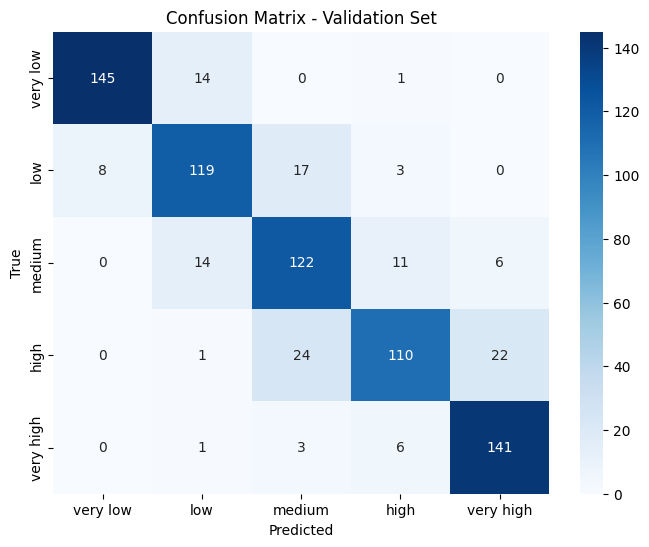

-----------------------------------------

Evaluating on Test Set...
Test Loss: 0.5426, Test Accuracy: 0.8060
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Evaluation Metrics for Test Set ---
Macro F1 Score: 0.8035

Confusion Matrix:


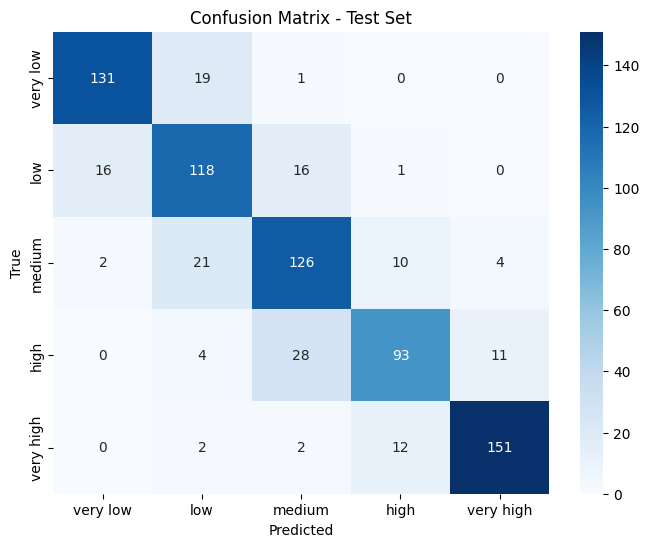

-----------------------------------------

Production Classification Task Completed.


In [39]:


    # Validation Set Evaluation
    print("\nEvaluating on Validation Set...")
    val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val_encoded, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    y_val_pred_probs = model.predict(X_val_reshaped)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)
    print_cnn_evaluation_metrics(y_val_binned, y_val_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Validation Set")

    # Test Set Evaluation
    print("\nEvaluating on Test Set...")
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    y_test_pred_probs = model.predict(X_test_reshaped)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
    print_cnn_evaluation_metrics(y_test_binned, y_test_pred_classes, actual_n_classes, CLASS_LABELS, dataset_name="Test Set")

    print("\nProduction Classification Task Completed.")

